In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from itertools import combinations

### Accuracy

In [ ]:
result_path = "/home/acg17270jl/projects/fmri-reconstruction-with-dmvae/results/deeprecon/conversion/"

train_subj_tapple = (1, 2, 3, 4, 5)
selected_subj_tapple = (1, 2, 3, 4, 5)

# pattern_corr_file_name = f"pattern_correlation_dmvae_subj{''.join(map(str, train_subj_tapple))}.csv"
# pattern_corr_file_name = "pattern_correlation_converter_regression.csv"
pattern_corr_file_name = "pattern_correlation_converter2.csv"
pattern_nc_file_name = "pattern_noise_ceiling.csv"
pattern_nc_thd_file_name = "pattern_noise_ceiling_threshold.csv"

pattern_corr_df = pd.read_csv(os.path.join(result_path, pattern_corr_file_name))
pattern_nc_df = pd.read_csv(os.path.join(result_path, pattern_nc_file_name))
pattern_nc_thd_df = pd.read_csv(os.path.join(result_path, pattern_nc_thd_file_name))

In [ ]:
selected_subj_pairs = set(itertools.permutations(selected_subj_tapple, 2))
select_mask = pattern_corr_df[["Subject_target", "Subject_source"]].apply(tuple, axis=1).isin(selected_subj_pairs)
pattern_corr_df = pattern_corr_df[select_mask]

In [43]:
pattern_nc_df['identifier'] = pattern_nc_df['Subject'].values.astype(str) + pattern_nc_df['Image_idx'].values.astype(str)
pattern_nc_thd_df['identifier'] = pattern_nc_thd_df['Subject'].values.astype(str) + pattern_nc_thd_df['Image_idx'].values.astype(str)
pattern_nc_df = pattern_nc_df.join(pattern_nc_thd_df.set_index('identifier'), rsuffix='_', on='identifier')

pattern_corr_df['identifier'] = pattern_corr_df['Subject_target'].values.astype(str) + pattern_corr_df['Image_idx'].values.astype(str)

In [46]:
pattern_corr_df = pattern_corr_df.merge(pattern_nc_df, on='identifier', suffixes=('', '_nc'))

In [48]:
pattern_corr_df.drop(pattern_corr_df.loc[pattern_corr_df['Correlation_nc'] <= pattern_corr_df['Threshold_99']].index, inplace=True)

In [49]:
pattern_corr_df['Normalized correlation'] = np.clip(np.nan_to_num(pattern_corr_df['Correlation'].values / pattern_corr_df['Correlation_nc'].values), a_min=-1, a_max=1)

### Plot

In [221]:
figure_output_path = "/home/acg17270jl/projects/fmri-reconstruction-with-dmvae/figures/deeprecon"

### Compare effects of train subj numbers

In [175]:
from itertools import combinations

train_subj_tapple = (1, 2, 3, 4, 5)

selected_subj_tapple_list = list(combinations(train_subj_tapple, 2))
print(selected_subj_tapple_list) 

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]


In [176]:
def supersets_of_pair(tapple_pair, universe):
    out = []
    pair_set = set(tapple_pair)
    for k in range(2, len(universe) + 1):
        for comb in combinations(universe, k):
            if pair_set.issubset(comb):
                out.append((comb)) 
    return out

selected_subj_tapple_supersets_dict = {selected_subj_tapple: supersets_of_pair(selected_subj_tapple, train_subj_list) for selected_subj_tapple in selected_subj_tapple_list}


In [177]:
result_path = "/home/acg17270jl/projects/fmri-reconstruction-with-dmvae/results/deeprecon/conversion/"

scores_2 = []
scores_3 = []
scores_4 = []
scores_5 = []

for selected_subj_tapple in selected_subj_tapple_list:
    print("=====")
    print(selected_subj_tapple)
    selected_subj_tapple_supersets = supersets_of_pair(selected_subj_tapple, train_subj_list)

    for selected_subj_tapple_superset in selected_subj_tapple_supersets:
        print(selected_subj_tapple_superset)

        pattern_corr_file_name = f"pattern_correlation_dmvae_subj{''.join(map(str, selected_subj_tapple_superset))}.csv"
        pattern_nc_file_name = "pattern_noise_ceiling.csv"
        pattern_nc_thd_file_name = "pattern_noise_ceiling_threshold.csv"

        pattern_corr_df = pd.read_csv(os.path.join(result_path, pattern_corr_file_name))
        pattern_nc_df = pd.read_csv(os.path.join(result_path, pattern_nc_file_name))
        pattern_nc_thd_df = pd.read_csv(os.path.join(result_path, pattern_nc_thd_file_name))

        selected_subj_pairs = set(itertools.permutations(selected_subj_tapple, 2))
        select_mask = pattern_corr_df[["Subject_target", "Subject_source"]].apply(tuple, axis=1).isin(selected_subj_pairs)
        pattern_corr_df = pattern_corr_df[select_mask]

        pattern_nc_df['identifier'] = pattern_nc_df['Subject'].values.astype(str) + pattern_nc_df['Image_idx'].values.astype(str)
        pattern_nc_thd_df['identifier'] = pattern_nc_thd_df['Subject'].values.astype(str) + pattern_nc_thd_df['Image_idx'].values.astype(str)
        pattern_nc_df = pattern_nc_df.join(pattern_nc_thd_df.set_index('identifier'), rsuffix='_', on='identifier')

        pattern_corr_df['identifier'] = pattern_corr_df['Subject_target'].values.astype(str) + pattern_corr_df['Image_idx'].values.astype(str)
                
        pattern_corr_df = pattern_corr_df.merge(pattern_nc_df, on='identifier', suffixes=('', '_nc'))

        pattern_corr_df.drop(pattern_corr_df.loc[pattern_corr_df['Correlation_nc'] <= pattern_corr_df['Threshold_99']].index, inplace=True)

        pattern_corr_df['Normalized correlation'] = np.clip(np.nan_to_num(pattern_corr_df['Correlation'].values / pattern_corr_df['Correlation_nc'].values), a_min=-1, a_max=1)

        series = pattern_corr_df['Normalized correlation']
        scores = series.groupby(np.arange(len(series)) // 50).mean().tolist()

        if len(selected_subj_tapple_superset) == 2:
            for score in scores:
                scores_2.append(score)
        elif len(selected_subj_tapple_superset) == 3:
            for score in scores:
                scores_3.append(score)
        elif len(selected_subj_tapple_superset) == 4:
            for score in scores:
                scores_4.append(score)
        elif len(selected_subj_tapple_superset) == 5:
            for score in scores:
                scores_5.append(score)

=====
(1, 2)
(1, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 3, 4)
(1, 2, 3, 5)
(1, 2, 4, 5)
(1, 2, 3, 4, 5)
=====
(1, 3)
(1, 3)
(1, 2, 3)
(1, 3, 4)
(1, 3, 5)
(1, 2, 3, 4)
(1, 2, 3, 5)
(1, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(1, 4)
(1, 4)
(1, 2, 4)
(1, 3, 4)
(1, 4, 5)
(1, 2, 3, 4)
(1, 2, 4, 5)
(1, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(1, 5)
(1, 5)
(1, 2, 5)
(1, 3, 5)
(1, 4, 5)
(1, 2, 3, 5)
(1, 2, 4, 5)
(1, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(2, 3)
(2, 3)
(1, 2, 3)
(2, 3, 4)
(2, 3, 5)
(1, 2, 3, 4)
(1, 2, 3, 5)
(2, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(2, 4)
(2, 4)
(1, 2, 4)
(2, 3, 4)
(2, 4, 5)
(1, 2, 3, 4)
(1, 2, 4, 5)
(2, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(2, 5)
(2, 5)
(1, 2, 5)
(2, 3, 5)
(2, 4, 5)
(1, 2, 3, 5)
(1, 2, 4, 5)
(2, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(3, 4)
(3, 4)
(1, 3, 4)
(2, 3, 4)
(3, 4, 5)
(1, 2, 3, 4)
(1, 3, 4, 5)
(2, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(3, 5)
(3, 5)
(1, 3, 5)
(2, 3, 5)
(3, 4, 5)
(1, 2, 3, 5)
(1, 3, 4, 5)
(2, 3, 4, 5)
(1, 2, 3, 4, 5)
=====
(4, 5)
(4, 5)
(1, 4, 5)
(2, 4, 5)
(3, 4, 5)
(1, 2

In [178]:
print(len(scores_2))
print(len(scores_3))
print(len(scores_4))
print(len(scores_5))

20
60
60
20


In [179]:
print(scores_2)
print(scores_3)
print(scores_4)
print(scores_5)

[0.6097875167542095, 0.6556039573826385, 0.6011977215208981, 0.6876976383146618, 0.6110449981665245, 0.6566356936699371, 0.6066683986905086, 0.49645689376194296, 0.6491736312965247, 0.6713778881549167, 0.6547981835405297, 0.6400182380373827, 0.6430752613569265, 0.4788695633039623, 0.6879280618899234, 0.6428679193582506, 0.6727982570015695, 0.4750331138743906, 0.6329934471920579, 0.48147279278573135]
[0.6148425921615358, 0.6521041930149021, 0.6082659022604028, 0.6605611310858308, 0.6170974627939008, 0.6498772890254423, 0.616059835374609, 0.6923437948795307, 0.6192318588555206, 0.707067055013822, 0.6025222813873852, 0.6919397288419765, 0.6097898866770919, 0.6527524400163662, 0.6202268549434808, 0.6513679668999036, 0.6018478909734134, 0.6489108706447692, 0.6149070227313073, 0.4809782482613913, 0.5994556746588608, 0.4847120731295995, 0.5981754040163174, 0.4856284289332101, 0.6496180658888997, 0.6856549161554022, 0.661975184651403, 0.6878636878781796, 0.6570258523412847, 0.6834910484655166,

In [180]:
print(np.array(scores_2).mean())
print(np.array(scores_3).mean())
print(np.array(scores_4).mean())
print(np.array(scores_5).mean())

0.6127749588026743
0.616120057724649
0.6161797680825066
0.6161049702122443


In [181]:
print(np.array(scores_2).std())
print(np.array(scores_3).std())
print(np.array(scores_4).std())
print(np.array(scores_5).std())

0.06927443196671502
0.07257009452819897
0.0727467396820833
0.07568234865612042


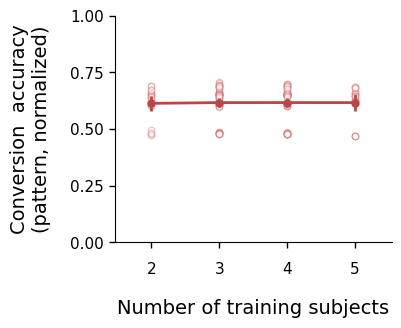

95% CI half-width for 2: 0.033264
95% CI half-width for 3: 0.018905
95% CI half-width for 4: 0.018951
95% CI half-width for 5: 0.036341
Saved to: /home/acg17270jl/projects/fmri-reconstruction-with-dmvae/figures/deeprecon/conversion_accuracy_pattern_nsubjects.png


In [224]:
import os
import numpy as np
import matplotlib.pyplot as plt

# --- データ ---
group_keys = [2, 3, 4, 5]
all_scores = {
    2: scores_2,
    3: scores_3,
    4: scores_4,
    5: scores_5,
}

# --- 色（赤系を統一） ---
scatter_edge = "#D66565"   # 点の縁
mean_color   = "#B94747"   # 平均点・線・エラーバー

# --- 平均・95%CI（t分布; SciPyがなければ Z=1.96 近似） ---
means = {k: float(np.mean(all_scores[k]))        for k in group_keys}
sds   = {k: float(np.std(all_scores[k], ddof=1)) for k in group_keys}
ns    = {k: int(len(all_scores[k]))              for k in group_keys}

try:
    from scipy.stats import t as _t
    def t_crit(df): return float(_t.ppf(0.975, df))
except Exception:
    def t_crit(df): return 1.96  # フォールバック（大標本近似）

ci_half = {
    k: (t_crit(ns[k]-1) * sds[k] / np.sqrt(ns[k])) if ns[k] >= 2 else 0.0
    for k in group_keys
}

# --- 配置を少し右寄せ＆後半詰め（非等間隔） ---
x_pos = {2: 2, 3: 3, 4: 4, 5: 5}

# --- 図作成 ---
fig, ax = plt.subplots(figsize=(4.2, 4.2))
fig.subplots_adjust(left=0.24, bottom=0.34)

# --- 個々のスコアの散布（白抜き丸, クリップ抑制） ---
for k in group_keys:
    scores = all_scores[k]
    x = np.full(len(scores), float(x_pos[k]))
    ax.scatter(
        x, scores,
        s=22, marker="o",
        facecolors="white",
        edgecolors=scatter_edge,
        linewidths=0.8,
        alpha=0.4, zorder=3,
        clip_on=False,
    )

# --- 平均＋95%CI（縦棒のみ, クリップ抑制） ---
x_vals = np.array([x_pos[k] for k in group_keys], dtype=float)
y_vals = np.array([means[k]   for k in group_keys], dtype=float)
y_errs = np.array([ci_half[k] for k in group_keys], dtype=float)

ax.errorbar(
    x_vals, y_vals, yerr=y_errs,
    fmt='o-', markersize=5, linewidth=2.0,
    capsize=0, elinewidth=2.0,
    color=mean_color, markerfacecolor=mean_color, markeredgecolor=mean_color,
    zorder=4,
    clip_on=False,
)

# --- 軸やラベル ---
ax.set_xticks(x_vals)
ax.set_xticklabels([str(k) for k in group_keys], ha="center")

# ※ ここがポイント：xlim は指定しないでマージンを使う（切れ防止）
ax.margins(x=0.18)  # 余白を少し広めに

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.01, 0.25))

ax.set_xlabel("Number of training subjects", labelpad=16, fontsize=14)
ax.set_ylabel("Conversion  accuracy\n(pattern, normalized)", labelpad=14, fontsize=14)

ax.tick_params(axis="both", labelsize=11)
ax.grid(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(
    axis="both", which="both",
    direction="out", length=4, width=1.0,
    bottom=True, top=False, left=True, right=False,
)
ax.tick_params(axis="x", pad=10)

# --- 保存＆表示 ---
out_png = os.path.join(figure_output_path, "conversion_accuracy_pattern_nsubjects.png")
# bbox_inches="tight" は切れやすいので外す。使うなら pad を必ず付ける:
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

# --- 確認出力 ---
for k in group_keys:
    print(f"95% CI half-width for {k}: {y_errs[group_keys.index(k)]:.6f}")
print(f"Saved to: {out_png}")

#### Pattern conversion accuracy per method

In [ ]:
series = pattern_corr_df['Normalized correlation']
mlp_means = series.groupby(np.arange(len(series)) // 50).mean().tolist()

In [19]:
dmvae_means

[0.6258639099339693,
 0.6266935635768858,
 0.6256049071959909,
 0.6233908669166496,
 0.6566638464797789,
 0.6568078871533848,
 0.6564669171137416,
 0.6561568535212103,
 0.6857218517486882,
 0.6824731212581129,
 0.6844101332363178,
 0.6820284072371048,
 0.6465295566138135,
 0.6456383211574146,
 0.646523441353711,
 0.6430568388112238,
 0.47038236216943835,
 0.46965441648416617,
 0.4706391016810455,
 0.4673931006022375]

In [36]:
regression_means

[0.4135636290884394,
 0.38693924574377087,
 0.36570051677198867,
 0.15038611674016297,
 0.2615503919599368,
 0.45415821148053864,
 0.43918101219855515,
 0.16651531876555464,
 0.25627430755087643,
 0.4506446142110208,
 0.4406868014162411,
 0.1716129859246457,
 0.2757568894966705,
 0.46415568950276553,
 0.4701874957982362,
 0.16924006556266427,
 0.15730849717345402,
 0.28220461337058483,
 0.27306574774013737,
 0.25458217190203836]

In [53]:
mlp_means

[0.02663580358064583,
 0.028831695824363544,
 0.02118189116540502,
 0.006722356106626911,
 0.020207952256318603,
 0.026845271505606342,
 0.028748388787269884,
 0.009615497623815023,
 0.016446408570044934,
 0.03438984267801016,
 0.021846710431442914,
 0.012105273119414103,
 0.0207420770231615,
 0.044556596149215276,
 0.033171240714049206,
 0.0105273708124258,
 0.020099801750720375,
 0.01967647408472023,
 0.019561372343487086,
 0.015313059753634646]

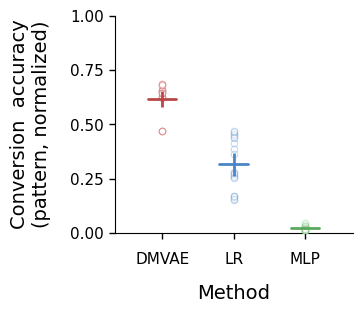

DMVAE: n=20, SD=0.077648, SE=0.017363, 95% CI half-width=0.036341
Regression: n=20, SD=0.117635, SE=0.026304, 95% CI half-width=0.055055
MLP: n=20, SD=0.009280, SE=0.002075, 95% CI half-width=0.004343
Saved to: /home/acg17270jl/projects/fmri-reconstruction-with-dmvae/figures/deeprecon/conversion_accuracy_pattern_method.png


In [225]:
import os
import numpy as np
import matplotlib.pyplot as plt

methods = ["DMVAE", "Regression", "MLP"]          # データ順の識別用（変更しない）
display_labels = ["DMVAE", "LR", "MLP"]           # Regression を "LR" に
all_scores = [dmvae_means, regression_means, mlp_means]

# ---- 配置設定（Regressionはそのまま2、MLPは右、DMVAEは左）----
positions = {
    "DMVAE": 1.7,
    "Regression": 2.0,
    "MLP": 2.3,
}

# コンパクトな図
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# --- 散布図（白抜き丸、横ジッターなし） ---
edge_color_map = {
    "DMVAE": "#D66565",      # red
    "Regression": "#5F98D1", # blue
    "MLP": "#6FBC6F",        # green
}
for name, scores in zip(methods, all_scores):
    xval = positions[name]
    x = np.full(len(scores), xval)
    ax.scatter(
        x, scores,
        s=22, marker="o",
        facecolors="white",
        edgecolors=edge_color_map[name],
        linewidths=0.8, alpha=0.35, zorder=3,
    )

# --- 平均と95%CI（ddof=1 の不偏分散を使用） ---
means = {name: float(np.mean(scores)) for name, scores in zip(methods, all_scores)}
ns    = {name: int(len(scores))       for name, scores in zip(methods, all_scores)}
sds   = {name: float(np.std(scores, ddof=1)) for name, scores in zip(methods, all_scores)}
ses   = {name: (sds[name] / np.sqrt(ns[name])) for name in methods}

# t* の算出（scipy があれば t 分布、なければ z=1.96 にフォールバック）
try:
    from scipy import stats
    tcrit = {name: float(stats.t.ppf(0.975, df=ns[name]-1)) for name in methods}
except Exception:
    tcrit = {name: 1.96 for name in methods}  # 近似

half_ci = {name: tcrit[name] * ses[name] for name in methods}  # 95%CI の半幅

# --- 誤差（縦棒：95%CI） + 平均の横棒 ---
mean_bar_color_map = {
    "DMVAE": "#B94747",
    "Regression": "#4B85C5",
    "MLP": "#59A85F",
}
bar_half_width = 0.060
bar_lw = 2.0
err_lw = 2.0

# 縦棒（95%CI）：各平均 m を中心に m±half_ci を vlines で描画
for name in methods:
    cx = positions[name]
    m  = means[name]
    ci = half_ci[name]
    ax.vlines(
        cx, m - ci, m + ci,
        colors=mean_bar_color_map[name],
        linewidth=err_lw, zorder=3.5,
    )

# 平均の横棒（最後に重ねる）
for name in methods:
    m = means[name]
    cx = positions[name]
    ax.plot(
        [cx - bar_half_width, cx + bar_half_width],
        [m, m],
        color=mean_bar_color_map[name],
        linewidth=bar_lw,
        solid_capstyle="round",
        zorder=4,
    )

# --- 軸やラベル ---
xticks = [positions[m] for m in methods]
ax.set_xticks(xticks)
ax.set_xticklabels(display_labels, ha="center")
ax.set_xlim(min(xticks) - 0.2, max(xticks) + 0.2)

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.01, 0.25))

ax.set_xlabel("Method", labelpad=12, fontsize=14)
ax.set_ylabel("Conversion  accuracy\n(pattern, normalized)", labelpad=14, fontsize=14)

ax.tick_params(axis="both", labelsize=11)
ax.grid(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(
    axis="both", which="both",
    direction="out", length=4, width=1.0,
    bottom=True, top=False, left=True, right=False,
)
ax.tick_params(axis="x", pad=10)
fig.subplots_adjust(left=0.22, bottom=0.26)

# --- 保存＆表示 ---
out_png = os.path.join(figure_output_path, "conversion_accuracy_pattern_method.png")
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()

# --- 確認出力（任意） ---
for name in methods:
    n  = ns[name]
    sd = sds[name]
    se = ses[name]
    ci = half_ci[name]
    print(f"{name}: n={n}, SD={sd:.6f}, SE={se:.6f}, 95% CI half-width={ci:.6f}")
print(f"Saved to: {out_png}")